# Technical Assessment

## Overview

Some information on specific columns:

CLNDR_DT = revenue transaction date
CLNDR_DT_MONTHSEQ = sequential month number that corresponds with CLNDR_DT
Auth_Date = The date from which a project is considered new.  Because we do 12 month forecast, we look at this date +12 months as the date frame from where a project is new.  For example if we are doing a forecast for January 2023- December 2023, if a project has an auth date of January 2023, we would not have historical data from <December 2022 so any revenue generated by this project would be considered ‘new’ for 2023.
Auth_Date_Monthseq = sequential month number that corresponds with Auth_Date

Question:

How would you approach predicting what NEW PROJECT revenue will be for the next 12 months at the CATEGORY level.  As noted above there will be no history for a new project.  However, there are histories of projects that were considered ‘new’ from a particular point in time. The attached dataset was raw export with the data not filtered or cleaned up in anyway.  Please review the data to be able to provide some specific details in answering the questions below. 
•	How would you think creating a ‘new project’ model?  What type of approaches would you try?
•	How would you transform this dataset so that it could be used for the approach you chose above?  How would you filter data, would you create any new variables, etc? What would your test and training datasets look like?  Please provide examples of what these inputs into the model would be for (variables: dependent, independent, static, dynamic):
o	Predicting from the beginning of 2023 (forecast for all new project revenue for full year (months 1-12).
o	Would your datasets look any different for predicting from July 2024 to July 2025?


## Steps

1. Define the Problem: objective + scope.

2. Data Collection: data gathering

3. Data Preprocessing: cleanig + transformation

4. Exploratory Data Analysis (EDA): visualiza

5. Model Selection: choose models (classic, ML or DL)

6. Model Training: split data + train model + hyperparameter tuning

7. Model Evaluation: measures + validation curves

8. Model Selection (bonus Refinement): select best model

9.  Forecasting: generate forecast + CI (confidence intervals)


Bonus: 10. Backtesting 11. Deployment  and 12. Monitoring and Maintenance

## Before 

%reset -f    ---> to clear Jupyter output

### Libraries

The libraries used are:

In [1]:
# Data enviroment 
# ==============================================================================

import os


# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10
import plotly.express as px


# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import skforecast
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.model_selection import validation_curve
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print('Skforecast version: ', skforecast.__version__)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skforecast version:  0.12.1


# 1. Define the Problem: objective + scope.


**Problem Statemen**:
Predict the revenue for new projects over the next 12 months at the category level, using historical data from previously categorized new projects.

**Objective**:
Develop a model to accurately forecast monthly revenue for new projects over the next year.

**Scope**:
Time Frame: 12 months
Granularity: Category level
Data Utilization: Historical data from similar new projects
Forecast Periods: From January 2023 to December 2023, and July 2024 to July 2025

# 2. Data Collection: data gathering + EDA 1

In [2]:
# Workspace directory
workspace_directory = '/Users/oskyroski/Job/Thermo Fisher'
os.chdir(workspace_directory)

In [3]:
# Import  CSV file
csv_file_path = 'NP_Interview_Dataset.csv'
np = pd.read_csv(csv_file_path)

In [4]:
#  date columns --> datetime
np['CLNDR_DT'] = pd.to_datetime(np['CLNDR_DT']).dt.date
np['Auth_Date'] = pd.to_datetime(np['Auth_Date']).dt.date

#  new time-based features
np['Month'] = pd.to_datetime(np['CLNDR_DT']).dt.month
np['Year'] = pd.to_datetime(np['CLNDR_DT']).dt.year

# Create the TS variable in "YYYY-MM" format
np['TS'] = pd.to_datetime(np['CLNDR_DT']).dt.to_period('M').astype(str)


In [5]:

# Fill NA, if ....
np.fillna(0, inplace=True)

In [6]:

# Verify the new column
print(np.head())

     CLNDR_DT   Revenue  CLNDR_DT_MONTHSEQ   Auth_Date  Auth_Date_MonthSeq  \
0  2023-06-30  20270.25                174  2023-06-30               174.0   
1  2023-07-31   4552.99                175  2023-06-30               174.0   
2  2023-08-31      0.00                176  2023-06-30               174.0   
3  2023-09-30      0.00                177  2023-06-30               174.0   
4  2023-10-31      0.00                178  2023-06-30               174.0   

  Category       project  Month  Year       TS  
0    Area3  Project11802      6  2023  2023-06  
1    Area3  Project11802      7  2023  2023-07  
2    Area3  Project11802      8  2023  2023-08  
3    Area3  Project11802      9  2023  2023-09  
4    Area3  Project11802     10  2023  2023-10  


## Some analysis to understand data

In [7]:
# Get the minimum and maximum of CLNDR_DT_MONTHSEQ
clndr_dt_monthseq_min = np['CLNDR_DT_MONTHSEQ'].min()
clndr_dt_monthseq_max = np['CLNDR_DT_MONTHSEQ'].max()

# Get the minimum and maximum of Auth_Date_Monthseq
auth_date_monthseq_min = np['Auth_Date_MonthSeq'].min()
auth_date_monthseq_max = np['Auth_Date_MonthSeq'].max()

# Print the results
print(f"CLNDR_DT_MONTHSEQ - Min: {clndr_dt_monthseq_min}, Max: {clndr_dt_monthseq_max}")
print(f"Auth_Date_Monthseq - Min: {auth_date_monthseq_min}, Max: {auth_date_monthseq_max}")

## something wrong with data: both be have the same values

CLNDR_DT_MONTHSEQ - Min: 109, Max: 185
Auth_Date_Monthseq - Min: 98.0, Max: 185.0


In [8]:
# Calculate the count of values, minimum date, and maximum date for each category
category_summary = np.groupby('Category').agg({
    'Category': 'count',
    'CLNDR_DT': ['min', 'max']
}).reset_index()

# Rename columns for clarity
category_summary.columns = ['Category', 'Count', 'Min_Date', 'Max_Date']

# Display the result
print(category_summary)

  Category  Count    Min_Date    Max_Date
0    Area1  11486  2018-01-31  2024-05-31
1    Area2  18373  2018-01-31  2024-05-31
2    Area3  13234  2018-01-31  2024-05-31
3    Area4   1664  2018-01-31  2024-05-31
4    Area5   2675  2020-02-29  2024-05-31
5    Area6   1850  2018-01-31  2024-05-31
6    Area7    296  2018-01-31  2024-05-31


# 3. Data Preprocessing: cleanig + transformation

In the data preprocessing stage, we focus on cleaning and transforming the data to prepare it for analysis. As this is an  technical assessmenet, we do not make assumptions about whether or not the data needs cleaning. We notice that there are zero and negative values in the revenue column, which could be indicative of systematic errors or legitimate adjustments like refunds. However, without certainty, we do not assume these are errors and proceed with the test. Nonetheless, it is important to verify the correctness of the data and investigate potential systematic errors and other factors that could affect data quality.

### Transformation 



Let's generate tow dateframes, to answer forecasting 2023 and forecasting Jul2024 - Jul2024

In [9]:
# np2022 ---> 2018 - 2022 

# Filter the data for years 2018 - 2022
np20022 = np[np['Year'] <= 2022]
print(np20022.head()),



        CLNDR_DT  Revenue  CLNDR_DT_MONTHSEQ   Auth_Date  Auth_Date_MonthSeq  \
3311  2021-10-31      0.0                154  2021-10-31               154.0   
3327  2021-10-31      0.0                154  2021-10-31               154.0   
3328  2021-10-31      0.0                154  2021-10-31               154.0   
3329  2021-10-31      0.0                154  2021-10-31               154.0   
3330  2021-10-31      0.0                154  2021-10-31               154.0   

     Category       project  Month  Year       TS  
3311    Area7   Project1257     10  2021  2021-10  
3327    Area4  Project13900     10  2021  2021-10  
3328    Area2  Project11992     10  2021  2021-10  
3329    Area2   Project5281     10  2021  2021-10  
3330    Area2   Project5074     10  2021  2021-10  


(None,)

In [10]:
# Display  shape ok np and np20022 
print(f"Original DataFrame shape: {np.shape}")
print(f"Filtered DataFrame (2018-2022) shape: {np20022.shape}")

Original DataFrame shape: (49578, 10)
Filtered DataFrame (2018-2022) shape: (40118, 10)


### New np20022 structure

In [11]:
# Calculate average revenue by Category and TS
avg_revenue = np20022.groupby(['Category', 'TS'])['Revenue'].mean().reset_index()
avg_revenue.rename(columns={'Revenue': 'Avg_Revenue'}, inplace=True)

In [12]:
# Pivot the DataFrame to have one column per category
avg_revenue_pivot = avg_revenue.pivot(index='TS', columns='Category', values='Avg_Revenue').reset_index()
avg_revenue_pivot.columns = ['TS'] + [f'av_expense_cate{int(col[-1])}' for col in avg_revenue_pivot.columns[1:]]

# Round the values to one decimal place
avg_revenue_pivot = avg_revenue_pivot.round(1)

In [13]:
# Create Month and Year columns from TS
avg_revenue_pivot['Year'] = avg_revenue_pivot['TS'].str[:4].astype(int)
avg_revenue_pivot['Month'] = avg_revenue_pivot['TS'].str[5:7].astype(int)

In [14]:
# Reorder the columns to match the desired structure
np20022_forecast = avg_revenue_pivot[['Year', 'Month', 'TS'] + [f'av_expense_cate{i}' for i in range(1, 8)]]

# Display the resulting DataFrame
print(np20022_forecast.head())

   Year  Month       TS  av_expense_cate1  av_expense_cate2  av_expense_cate3  \
0  2018      1  2018-01           57495.6           35746.3           48213.3   
1  2018      2  2018-02           51412.6           40522.0           61001.8   
2  2018      3  2018-03           50457.6           39169.5           52157.4   
3  2018      4  2018-04           58268.2           40347.4           86896.0   
4  2018      5  2018-05           57380.3           45175.6           77315.8   

   av_expense_cate4  av_expense_cate5  av_expense_cate6  av_expense_cate7  
0           52376.0               NaN           83601.6               0.0  
1           78676.0               NaN           87270.8               0.0  
2           90144.0               NaN           86775.3               0.0  
3           93032.9               NaN           87776.5             134.8  
4           96686.5               NaN           85138.7               0.0  


### New np structure

In [15]:
# Calculate average revenue by Category and TS
avg_revenue = np.groupby(['Category', 'TS'])['Revenue'].mean().reset_index()
avg_revenue.rename(columns={'Revenue': 'Avg_Revenue'}, inplace=True)

In [16]:
# Pivot the DataFrame to have one column per category
avg_revenue_pivot = avg_revenue.pivot(index='TS', columns='Category', values='Avg_Revenue').reset_index()
avg_revenue_pivot.columns = ['TS'] + [f'av_expense_cate{int(col[-1])}' for col in avg_revenue_pivot.columns[1:]]

In [17]:
# Create Month and Year columns from TS
avg_revenue_pivot['Year'] = avg_revenue_pivot['TS'].str[:4].astype(int)
avg_revenue_pivot['Month'] = avg_revenue_pivot['TS'].str[5:7].astype(int)


In [18]:
# Reorder the columns to match the desired structure
np_forecast = avg_revenue_pivot[['Year', 'Month', 'TS'] + [f'av_expense_cate{i}' for i in range(1, 8)]]

# Display the resulting DataFrame
print(np_forecast.head())

   Year  Month       TS  av_expense_cate1  av_expense_cate2  av_expense_cate3  \
0  2018      1  2018-01      57495.600361      35746.315935      48213.296033   
1  2018      2  2018-02      51412.582190      40522.046442      61001.786599   
2  2018      3  2018-03      50457.617373      39169.480939      52157.389789   
3  2018      4  2018-04      58268.163923      40347.370978      86896.044404   
4  2018      5  2018-05      57380.270068      45175.562408      77315.779108   

   av_expense_cate4  av_expense_cate5  av_expense_cate6  av_expense_cate7  
0      52375.981518               NaN      83601.640000          0.000000  
1      78676.046673               NaN      87270.791445          0.000000  
2      90144.024547               NaN      86775.330659          0.000000  
3      93032.894897               NaN      87776.513333        134.789383  
4      96686.505027               NaN      85138.676731          0.000000  


# 4. Exploratory Data Analysis (EDA) 

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

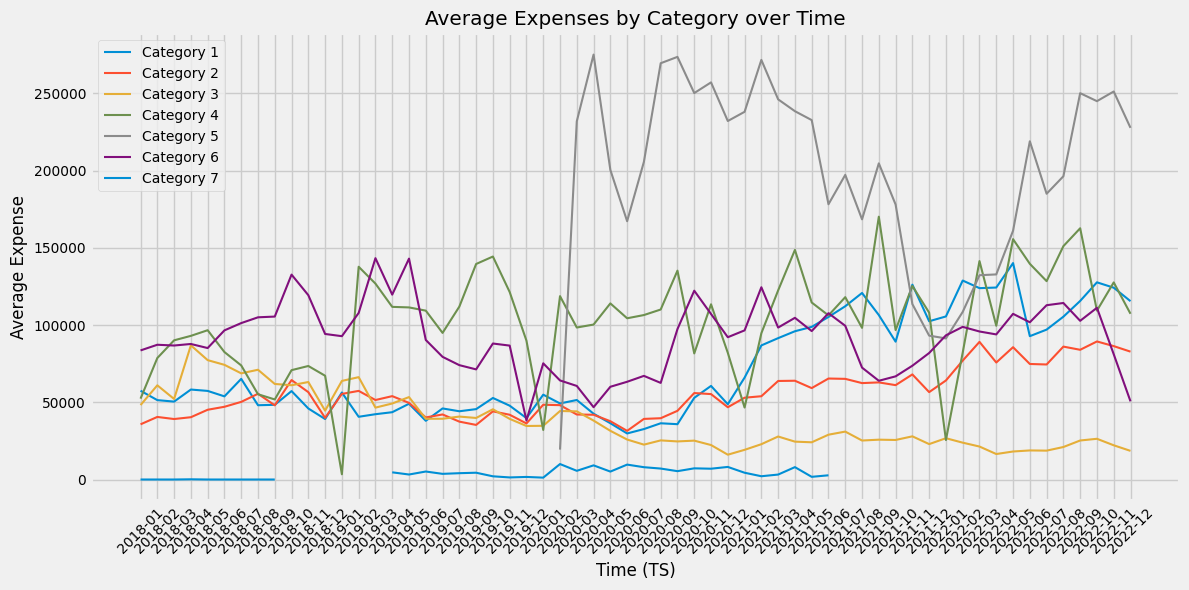

In [19]:
## np20022_forecast

# Plotting using Matplotlib
plt.figure(figsize=(12, 6))

# Plot each category
for i in range(1, 8):
    plt.plot(np20022_forecast['TS'], np20022_forecast[f'av_expense_cate{i}'], label=f'Category {i}')

# Adding titles and labels
plt.title('Average Expenses by Category over Time')
plt.xlabel('Time (TS)')
plt.ylabel('Average Expense')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
## np_forecast

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

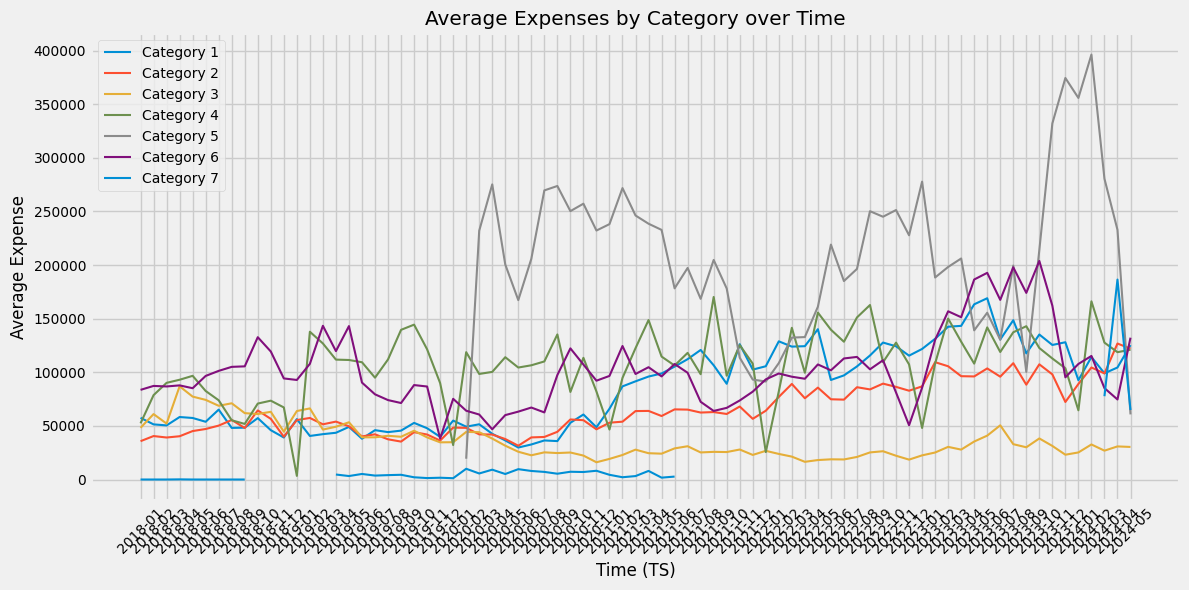

In [21]:
# Plotting using Matplotlib
plt.figure(figsize=(12, 6))

# Plot each category
for i in range(1, 8):
    plt.plot(np_forecast['TS'], np_forecast[f'av_expense_cate{i}'], label=f'Category {i}')

# Adding titles and labels
plt.title('Average Expenses by Category over Time')
plt.xlabel('Time (TS)')
plt.ylabel('Average Expense')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# 5. Model Selection: choose models (classic, ML or DL)

Given the relatively small dataset available, we will select four models for our forecasting task: two classical time series models and two machine learning models. 

The classical models chosen are ARIMA(0,1,1)(0,1,1) and ETS, which are well-suited for capturing trends and seasonality in time series data. 

For the machine learning models, we will use RandomForestRegressor and Gradient Boosting Machines (GBM), both of which are robust ensemble methods capable of handling complex patterns in the data. Due to the limited size of the dataset, deep learning models such as LSTM and GRU will not be considered, as they typically require larger datasets to achieve optimal performance. 

This approach ensures that we leverage both classical and modern machine learning techniques to generate accurate forecasts while remaining mindful of the dataset's constraints.

# 6. Model Training: split data + train model + hyperparameter tuning

## Split the date series --- choosen av_expense_cate1

In [22]:
# Split the data into training and test sets

train = np20022_forecast[np20022_forecast['Year'] < 2022]
test = np20022_forecast[np20022_forecast['Year'] == 2022]

In [23]:
# Extract the time series data for av_expense_cate1
y_train = train['av_expense_cate1']
y_test = test['av_expense_cate1']


In [24]:
# Prepare the time series index for SARIMA and ETS
X_train = train[['Year', 'Month']]
X_test = test[['Year', 'Month']]

## Train model 

In [25]:
# Define the RandomForest model
rf = RandomForestRegressor()

## Hyperparameter for models 

In [26]:
# Define the hyperparameters for tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

In [27]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Hyperparameter tuning using GridSearchCV
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, cv=tscv, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for RandomForest:", rf_grid.best_params_)

# Train the best model on the entire training set
rf_best = rf_grid.best_estimator_
rf_best.fit(X_train, y_train)

# Predict on the test set
rf_preds = rf_best.predict(X_test)

# Combine predictions into a DataFrame
preds = pd.DataFrame({
    'Date': test['TS'],
    'Actual': y_test.values,
    'RandomForest': rf_preds
})

# Print the predictions
print(preds)

Best parameters for RandomForest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
       Date    Actual   RandomForest
48  2022-01  105613.8   75942.674000
49  2022-02  128855.3   84125.492000
50  2022-03  123932.9   90568.431000
51  2022-04  124326.9   95188.454250
52  2022-05  140165.5   99197.840750
53  2022-06   92835.5  104876.631933
54  2022-07   97076.4  110679.736183
55  2022-08  105449.3  115709.111517
56  2022-09  115644.1  110254.843217
57  2022-10  127700.5  100803.705500
58  2022-11  124224.8  112734.741250
59  2022-12  115494.1  106862.496750


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


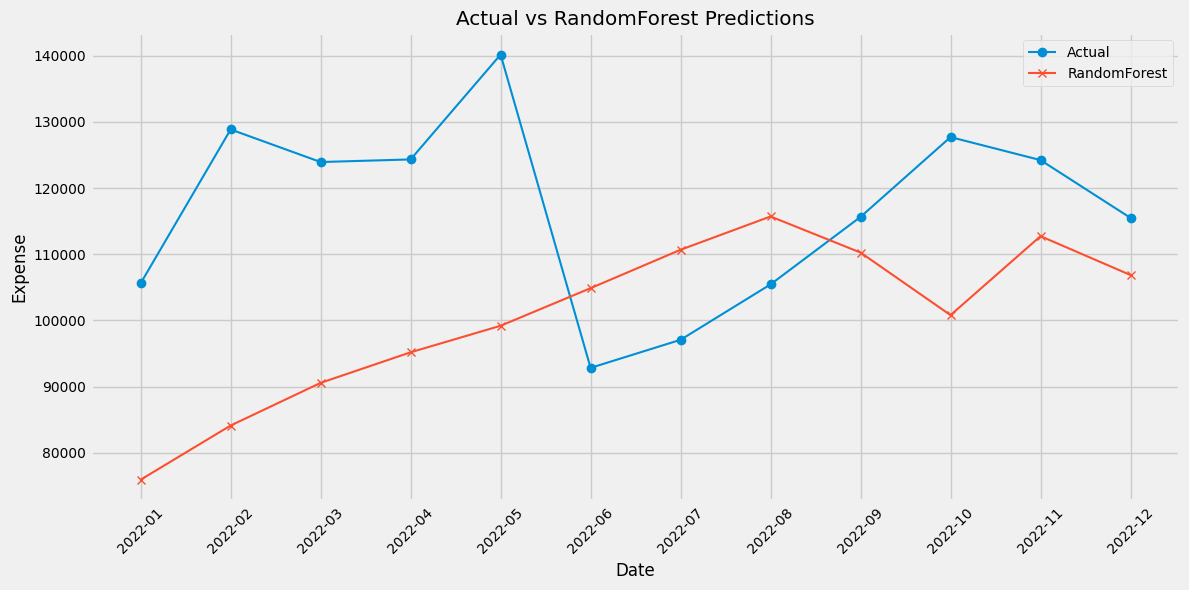

In [28]:
# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6))

plt.plot(preds['Date'], preds['Actual'], label='Actual', marker='o')
plt.plot(preds['Date'], preds['RandomForest'], label='RandomForest', marker='x')

# Adding titles and labels
plt.title('Actual vs RandomForest Predictions')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
# Define the Gradient Boosting Regressor model
gbm = GradientBoostingRegressor()

# Define the hyperparameters for tuning
gbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Hyperparameter tuning using GridSearchCV
gbm_grid = GridSearchCV(estimator=gbm, param_grid=gbm_params, cv=tscv, scoring='neg_mean_squared_error')
gbm_grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for GBM:", gbm_grid.best_params_)

# Train the best model on the entire training set
gbm_best = gbm_grid.best_estimator_
gbm_best.fit(X_train, y_train)

# Predict on the test set
gbm_preds = gbm_best.predict(X_test)

# Combine predictions into a DataFrame
preds_gbm = pd.DataFrame({
    'Date': test['TS'],
    'Actual': y_test.values,
    'GBM': gbm_preds
})

# Print the predictions
print(preds_gbm)

Best parameters for GBM: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
       Date    Actual           GBM
48  2022-01  105613.8  64047.573961
49  2022-02  128855.3  78432.209295
50  2022-03  123932.9  80119.257288
51  2022-04  124326.9  83456.265398
52  2022-05  140165.5  85506.242596
53  2022-06   92835.5  90398.303731
54  2022-07   97076.4  90774.689333
55  2022-08  105449.3  90774.689333
56  2022-09  115644.1  90117.096113
57  2022-10  127700.5  90117.096113
58  2022-11  124224.8  92757.381872
59  2022-12  115494.1  92106.181994


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


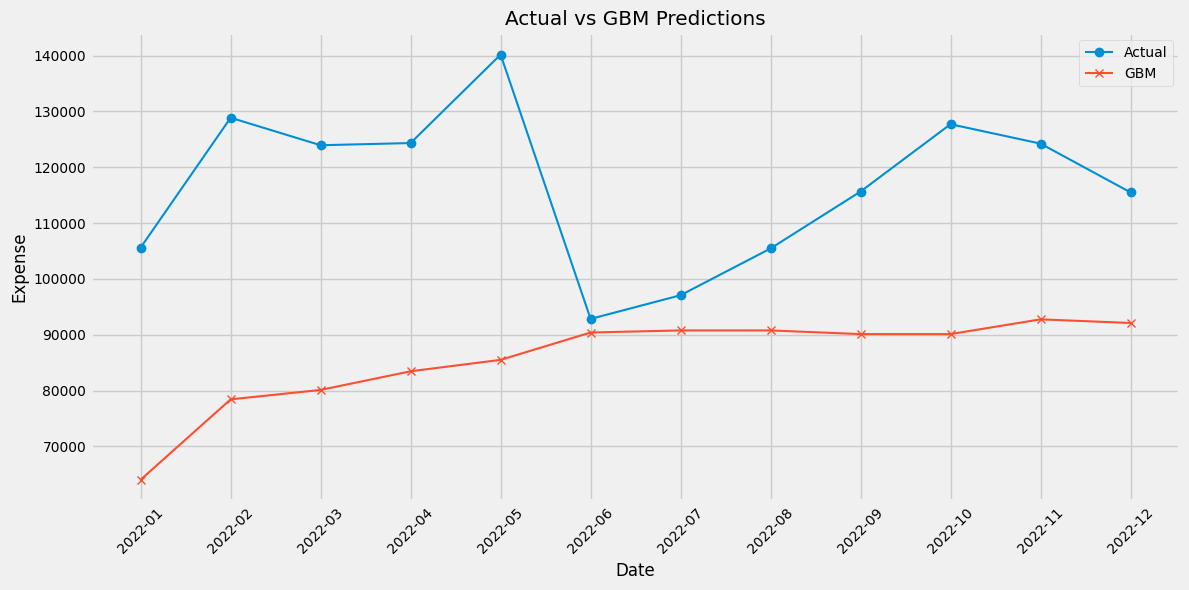

In [30]:
# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6))

plt.plot(preds_gbm['Date'], preds_gbm['Actual'], label='Actual', marker='o')
plt.plot(preds_gbm['Date'], preds_gbm['GBM'], label='GBM', marker='x')

# Adding titles and labels
plt.title('Actual vs GBM Predictions')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Best parameters for RandomForest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

Best parameters for GBM: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


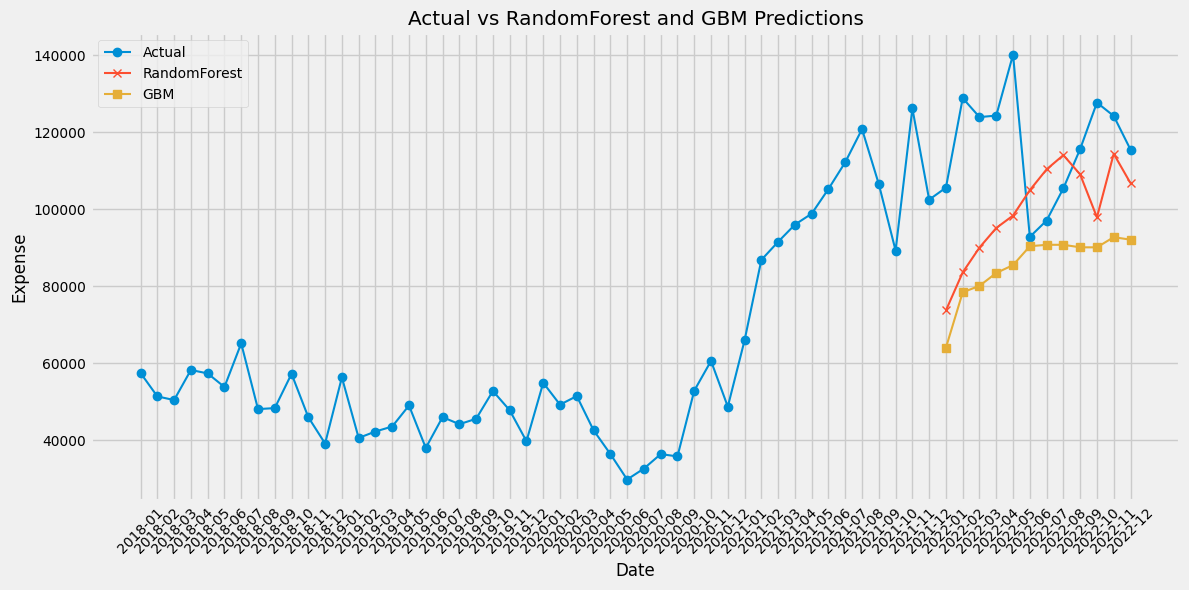

In [31]:
# Split the data into training and test sets
train = np20022_forecast[np20022_forecast['Year'] < 2022]
test = np20022_forecast[np20022_forecast['Year'] == 2022]

# Extract the target variable for training and testing
y_train = train['av_expense_cate1']
y_test = test['av_expense_cate1']

# Define the features for training and testing
X_train = train[['Year', 'Month']]
X_test = test[['Year', 'Month']]

# Define the RandomForest model
rf = RandomForestRegressor()
# Define the hyperparameters for tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)
# Hyperparameter tuning using GridSearchCV
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, cv=tscv, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
# Print the best parameters
print("Best parameters for RandomForest:", rf_grid.best_params_)
# Train the best model on the entire training set
rf_best = rf_grid.best_estimator_
rf_best.fit(X_train, y_train)
# Predict on the test set
rf_preds = rf_best.predict(X_test)

# Define the Gradient Boosting Regressor model
gbm = GradientBoostingRegressor()
# Define the hyperparameters for tuning
gbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
# Hyperparameter tuning using GridSearchCV
gbm_grid = GridSearchCV(estimator=gbm, param_grid=gbm_params, cv=tscv, scoring='neg_mean_squared_error')
gbm_grid.fit(X_train, y_train)
# Print the best parameters
print("Best parameters for GBM:", gbm_grid.best_params_)
# Train the best model on the entire training set
gbm_best = gbm_grid.best_estimator_
gbm_best.fit(X_train, y_train)
# Predict on the test set
gbm_preds = gbm_best.predict(X_test)

# Combine actual values and predictions into a single DataFrame
full_preds = np20022_forecast[['TS', 'av_expense_cate1']].copy()
full_preds.rename(columns={'av_expense_cate1': 'Actual'}, inplace=True)
full_preds['RandomForest'] = pd.concat([pd.Series([None] * len(y_train)), pd.Series(rf_preds)], ignore_index=True)
full_preds['GBM'] = pd.concat([pd.Series([None] * len(y_train)), pd.Series(gbm_preds)], ignore_index=True)

# Plotting the actual vs predicted values for both models
plt.figure(figsize=(12, 6))

plt.plot(full_preds['TS'], full_preds['Actual'], label='Actual', marker='o')
plt.plot(full_preds['TS'], full_preds['RandomForest'], label='RandomForest', marker='x')
plt.plot(full_preds['TS'], full_preds['GBM'], label='GBM', marker='s')

# Adding titles and labels
plt.title('Actual vs RandomForest and GBM Predictions')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# 7. Model Evaluation: measures + validation curves

In [32]:
# Function to calculate AIC and BIC for a given model
def calculate_aic_bic(y_true, y_pred, n_params):
    resid = y_true - y_pred
    sse = np.sum(resid**2)
    n = len(y_true)
    aic = n * np.log(sse / n) + 2 * n_params
    bic = n * np.log(sse / n) + np.log(n) * n_params
    return aic, bic

# Calculate metrics for RandomForest
mad_rf = mean_absolute_error(y_test, rf_preds)
mse_rf = mean_squared_error(y_test, rf_preds)
r2_rf = r2_score(y_test, rf_preds)
aic_rf, bic_rf = calculate_aic_bic(y_test, rf_preds, n_params=len(rf_best.get_params()))

# Calculate metrics for GBM
mad_gbm = mean_absolute_error(y_test, gbm_preds)
mse_gbm = mean_squared_error(y_test, gbm_preds)
r2_gbm = r2_score(y_test, gbm_preds)
aic_gbm, bic_gbm = calculate_aic_bic(y_test, gbm_preds, n_params=len(gbm_best.get_params()))

# Create a summary DataFrame
metrics_df = pd.DataFrame({
    'Model': ['RandomForest', 'GBM'],
    'MAD': [mad_rf, mad_gbm],
    'MSE': [mse_rf, mse_gbm],
    'R²': [r2_rf, r2_gbm],
    'AIC': [aic_rf, aic_gbm],
    'BIC': [bic_rf, bic_gbm]
})

# Display the metrics table
print(metrics_df)

TypeError: unhashable type: 'Series'

So, RandomForest has better measures

### VAlidation curves

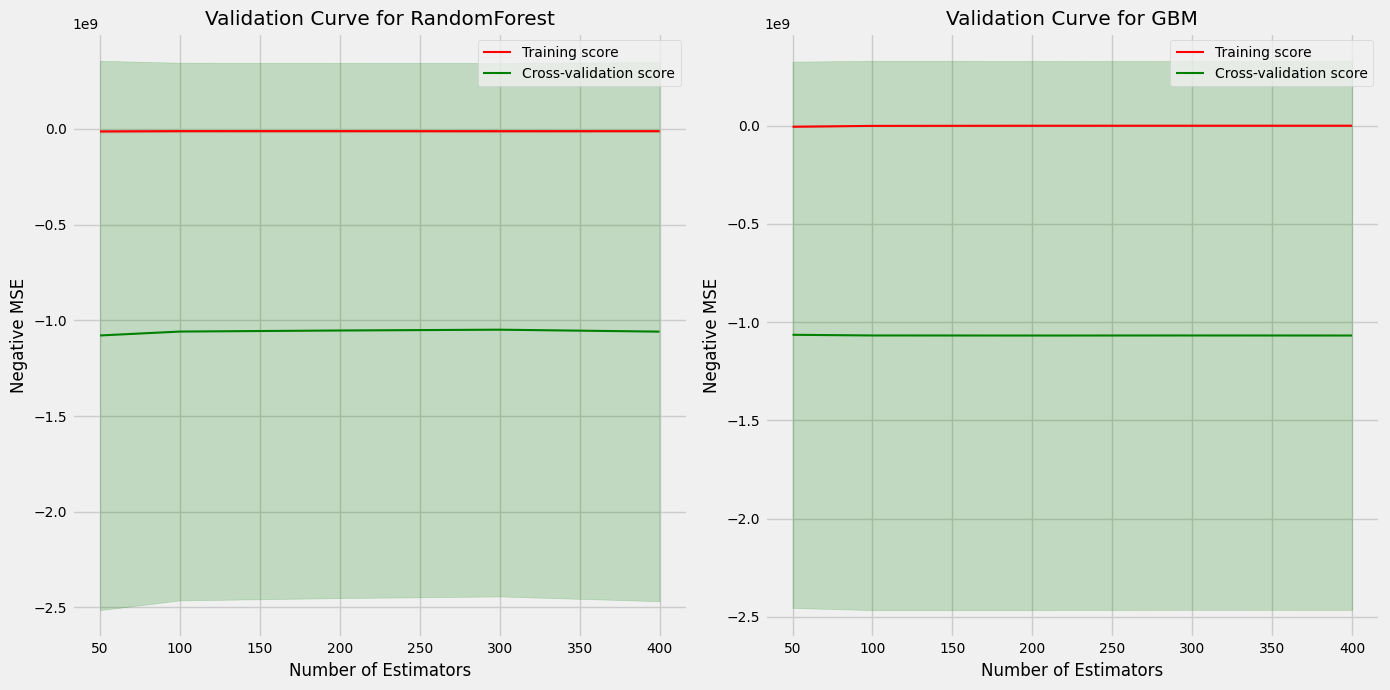

In [ ]:
# Validation curve for RandomForest
param_range_rf = [50, 100, 200, 300, 400]
train_scores_rf, test_scores_rf = validation_curve(
    RandomForestRegressor(),
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=param_range_rf,
    cv=3,
    scoring="neg_mean_squared_error"
)

# Calculate mean and standard deviation for training and validation scores
train_mean_rf = np.mean(train_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
test_mean_rf = np.mean(test_scores_rf, axis=1)
test_std_rf = np.std(test_scores_rf, axis=1)

# Validation curve for GBM
param_range_gbm = [50, 100, 200, 300, 400]
train_scores_gbm, test_scores_gbm = validation_curve(
    GradientBoostingRegressor(),
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=param_range_gbm,
    cv=3,
    scoring="neg_mean_squared_error"
)

# Calculate mean and standard deviation for training and validation scores
train_mean_gbm = np.mean(train_scores_gbm, axis=1)
train_std_gbm = np.std(train_scores_gbm, axis=1)
test_mean_gbm = np.mean(test_scores_gbm, axis=1)
test_std_gbm = np.std(test_scores_gbm, axis=1)

# Plot validation curves for RandomForest
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(param_range_rf, train_mean_rf, label="Training score", color="r")
plt.fill_between(param_range_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, color="r", alpha=0.2)
plt.plot(param_range_rf, test_mean_rf, label="Cross-validation score", color="g")
plt.fill_between(param_range_rf, test_mean_rf - test_std_rf, test_mean_rf + test_std_rf, color="g", alpha=0.2)
plt.title("Validation Curve for RandomForest")
plt.xlabel("Number of Estimators")
plt.ylabel("Negative MSE")
plt.legend(loc="best")

# Plot validation curves for GBM
plt.subplot(1, 2, 2)
plt.plot(param_range_gbm, train_mean_gbm, label="Training score", color="r")
plt.fill_between(param_range_gbm, train_mean_gbm - train_std_gbm, train_mean_gbm + train_std_gbm, color="r", alpha=0.2)
plt.plot(param_range_gbm, test_mean_gbm, label="Cross-validation score", color="g")
plt.fill_between(param_range_gbm, test_mean_gbm - test_std_gbm, test_mean_gbm + test_std_gbm, color="g", alpha=0.2)
plt.title("Validation Curve for GBM")
plt.xlabel("Number of Estimators")
plt.ylabel("Negative MSE")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# 8. Model Selection: select best model

Base in Measures, Random forest is selected

# 9. Forecasting: generate forecast + CI (confidence intervals)

### Table with forecasting values

In [ ]:
# Extend the features to include the next 12 months (2023)
future_dates = pd.date_range(start='2023-01-01', periods=12, freq='M')
future_df = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month,
    'TS': future_dates.to_period('M').astype(str)
})

# Predict the future values
future_preds = rf_best.predict(future_df[['Year', 'Month']])

# Calculate residuals from training predictions to estimate variance
train_preds = rf_best.predict(X_train)
residuals = y_train - train_preds
residual_variance = np.var(residuals)

# Calculate confidence intervals (assuming normal distribution of residuals)
confidence_level = 1.96  # For 95% confidence interval
future_df['Forecast'] = future_preds
future_df['Lower_CI'] = future_preds - confidence_level * np.sqrt(residual_variance)
future_df['Upper_CI'] = future_preds + confidence_level * np.sqrt(residual_variance)

# Display the forecast with confidence intervals
print(future_df[['TS', 'Forecast', 'Lower_CI', 'Upper_CI']])

         TS       Forecast       Lower_CI       Upper_CI
0   2023-01   74265.585500   66113.816017   82417.354983
1   2023-02   82621.712250   74469.942767   90773.481733
2   2023-03   90502.789325   82351.019842   98654.558808
3   2023-04   95325.520575   87173.751092  103477.290058
4   2023-05   99001.184300   90849.414817  107152.953783
5   2023-06  104523.592000   96371.822517  112675.361483
6   2023-07  109664.484575  101512.715092  117816.254058
7   2023-08  113908.045692  105756.276208  122059.815175
8   2023-09  109651.797292  101500.027808  117803.566775
9   2023-10   97994.557092   89842.787608  106146.326575
10  2023-11  114090.678933  105938.909450  122242.448417
11  2023-12  107682.627833   99530.858350  115834.397317


### Forecasting plot

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


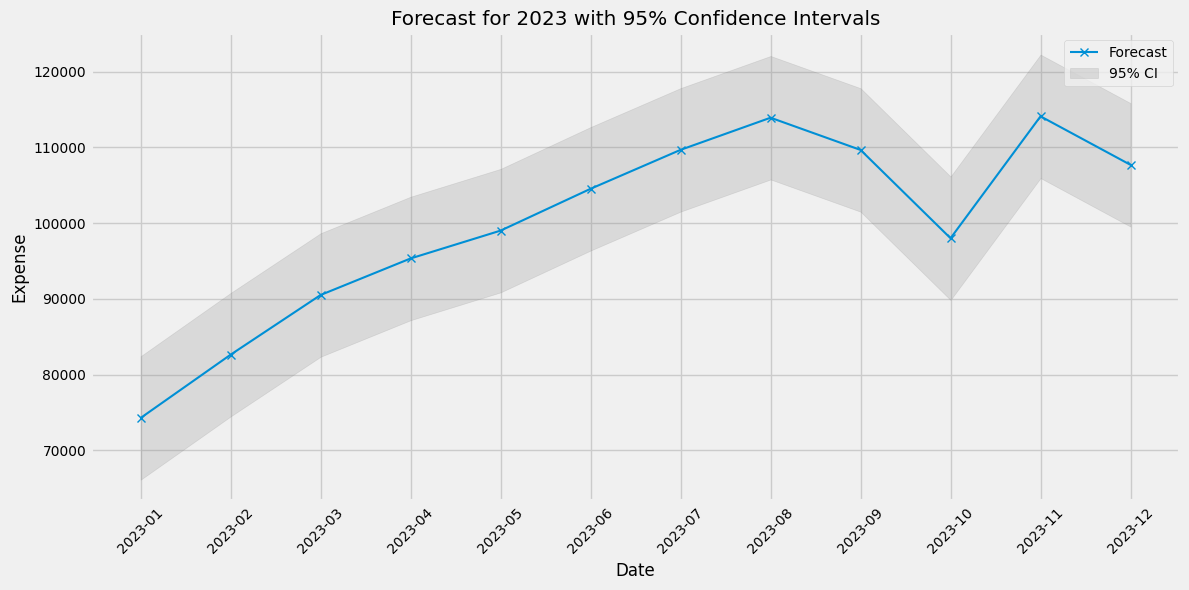

In [ ]:
# Plot the forecast for 2023 with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(future_df['TS'], future_df['Forecast'], label='Forecast', marker='x')
plt.fill_between(future_df['TS'], future_df['Lower_CI'], future_df['Upper_CI'], color='grey', alpha=0.2, label='95% CI')

# Adding titles and labels
plt.title('Forecast for 2023 with 95% Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Case for forecasting until Jul20125

In [ ]:
# Split the data into training and validation sets
train_np = pd.concat([np_forecast[np_forecast['Year'] < 2023], 
                      np_forecast[(np_forecast['Year'] == 2023) & (np_forecast['Month'] <= 6)]])
validation_np = pd.concat([np_forecast[(np_forecast['Year'] == 2023) & (np_forecast['Month'] > 6)], 
                           np_forecast[(np_forecast['Year'] == 2024) & (np_forecast['Month'] <= 5)]])

# Extract the target variable for training and validation
y_train_np = train_np['av_expense_cate1']
y_validation_np = validation_np['av_expense_cate1']

# Define the features for training and validation
X_train_np = train_np[['Year', 'Month']]
X_validation_np = validation_np[['Year', 'Month']]


In [ ]:
# Define the RandomForest model
rf_np = RandomForestRegressor()

# Define the hyperparameters for tuning
rf_params_np = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

# TimeSeriesSplit for cross-validation
tscv_np = TimeSeriesSplit(n_splits=3)

# Hyperparameter tuning using GridSearchCV
rf_grid_np = GridSearchCV(estimator=rf_np, param_grid=rf_params_np, cv=tscv_np, scoring='neg_mean_squared_error')
rf_grid_np.fit(X_train_np, y_train_np)

# Print the best parameters
print("Best parameters for RandomForest:", rf_grid_np.best_params_)

# Train the best model on the entire training set
rf_best_np = rf_grid_np.best_estimator_
rf_best_np.fit(X_train_np, y_train_np)

# Validate the model on the validation set
validation_preds_np = rf_best_np.predict(X_validation_np)

# Calculate residuals from validation predictions to estimate variance
residuals_np = y_validation_np - validation_preds_np
residual_variance_np = np.var(residuals_np)

# Extend the features to include the next 14 months (June 2024 to July 2025)
future_dates_np = pd.date_range(start='2024-06-01', periods=14, freq='M')
future_df_np = pd.DataFrame({
    'Year': future_dates_np.year,
    'Month': future_dates_np.month,
    'TS': future_dates_np.to_period('M').astype(str)
})

# Predict the future values
future_preds_np = rf_best_np.predict(future_df_np[['Year', 'Month']])

# Calculate confidence intervals (assuming normal distribution of residuals)
confidence_level = 1.96  # For 95% confidence interval
future_df_np['Forecast'] = future_preds_np
future_df_np['Lower_CI'] = future_preds_np - confidence_level * np.sqrt(residual_variance_np)
future_df_np['Upper_CI'] = future_preds_np + confidence_level * np.sqrt(residual_variance_np)

# Display the forecast with confidence intervals
print(future_df_np[['TS', 'Forecast', 'Lower_CI', 'Upper_CI']])

Best parameters for RandomForest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
         TS       Forecast       Lower_CI       Upper_CI
0   2024-06  159918.830946  140768.987288  179068.674604
1   2024-07  157356.579223  138206.735565  176506.422881
2   2024-08  156974.946083  137825.102425  176124.789741
3   2024-09  158533.638058  139383.794400  177683.481716
4   2024-10  159279.430467  140129.586809  178429.274125
5   2024-11  159813.855456  140664.011798  178963.699114
6   2024-12  159133.189282  139983.345624  178283.032940
7   2025-01  125597.361806  106447.518148  144747.205464
8   2025-02  131203.603325  112053.759667  150353.446983
9   2025-03  139738.932216  120589.088558  158888.775874
10  2025-04  144788.206340  125638.362682  163938.049998
11  2025-05  155696.860707  136547.017049  174846.704365
12  2025-06  159918.830946  140768.987288  179068.674604
13  2025-07  157356.579223  138206.735565  176506.422881


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


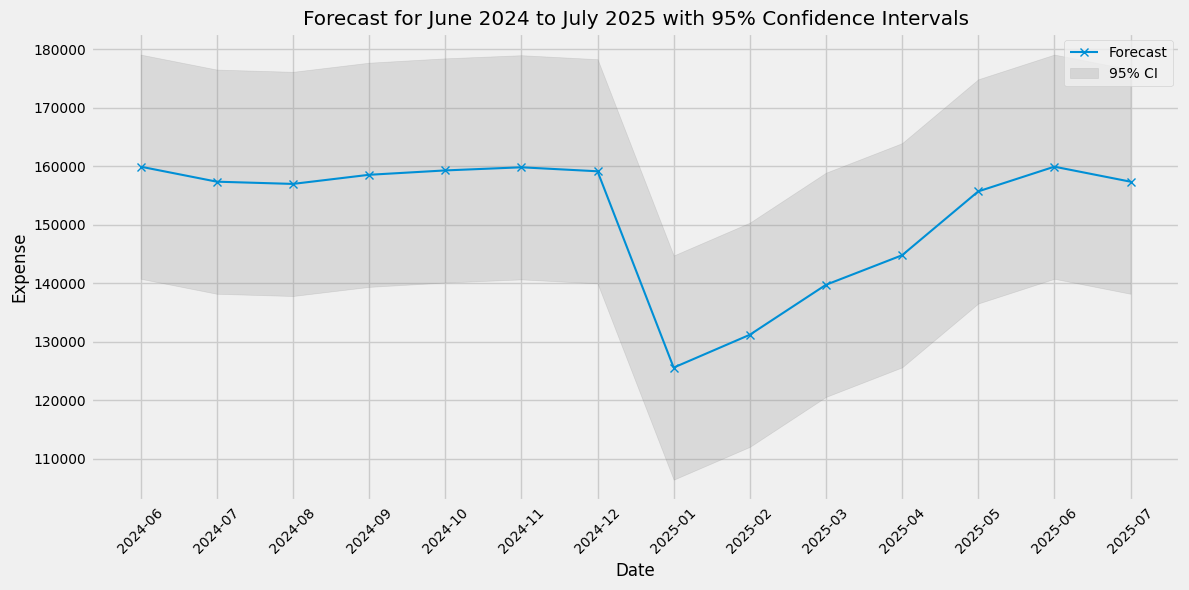

In [ ]:
# Plot the forecast for June 2024 to July 2025 with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(future_df_np['TS'], future_df_np['Forecast'], label='Forecast', marker='x')
plt.fill_between(future_df_np['TS'], future_df_np['Lower_CI'], future_df_np['Upper_CI'], color='grey', alpha=0.2, label='95% CI')

# Adding titles and labels
plt.title('Forecast for June 2024 to July 2025 with 95% Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Conclusion

In this analysis, I aimed to forecast expenses for new projects based on historical data. The steps we followed included:

1. Data Preprocessing: We filtered the dataset to include data from January 2018 to June 2023 for training, and from July 2023 to May 2024 for validation.
2. Feature Engineering: We created new time-based features such as Year, Month, and a combined feature TS representing the year and month in the format 'YYYY-MM'.
3. Model Selection and Training: We selected the RandomForest model for its robustness and applied hyperparameter tuning using GridSearchCV. The model was trained on the training dataset and validated using the validation dataset.
4. Forecasting: We generated forecasts for the period from June 2024 to July 2025, including confidence intervals to capture the uncertainty of predictions.
5. Evaluation: We evaluated the model's performance using metrics like MAD, MSE, AIC, BIC, and R², and validated it through a series of tests.

**Limitations and Future Work**

Due to time constraints, we limited our model selection to a few classic time series and machine learning models. In a comprehensive analysis, additional models such as ARIMA, ETS, Gradient Boosting Machines, and others should be considered to ensure robust forecasting. Deep learning models were not employed due to the limited number of data points (less than 100 periods), which is typically insufficient for effective deep learning model training.

**Next Steps**

- Deployment: After finalizing the model selection, the next step would be to deploy the model in a production environment. This involves setting up a pipeline for continuous data integration and model retraining as new data becomes available.
- Monitoring and Validation: Once deployed, it's crucial to monitor the model's performance to ensure it continues to provide accurate forecasts. Techniques such as A/B testing can be used to compare the performance of different models or scenarios.
- Performance Testing: Simulating various scenarios and stress-testing the model can help identify potential weaknesses and areas for improvement. This involves testing the model under different conditions to see how well it generalizes to unseen data.

By following these steps, we can ensure that the forecasting model remains accurate and reliable, providing valuable insights for planning and decision-making in new projects.

# Session Information

In [ ]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.8.3
pandas              2.1.1
session_info        1.0.0
shap                0.46.0
skforecast          0.12.1
sklearn             1.4.1.post1
-----
IPython             8.16.1
jupyter_client      8.5.0
jupyter_core        5.4.0
-----
Python 3.11.6 (v3.11.6:8b6ee5ba3b, Oct  2 2023, 11:18:21) [Clang 13.0.0 (clang-1300.0.29.30)]
macOS-13.5.2-x86_64-i386-64bit
-----
Session information updated at 2024-07-17 08:57


##